In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Masking, GRU, Flatten, Conv1D, LSTM, Bidirectional
from tensorflow.keras.layers import MaxPooling1D, BatchNormalization, Dropout, ZeroPadding1D
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score,roc_auc_score

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# ECG Rhythm 추출 Code

In [65]:
pred = model.predict(test)

# true_label = []
# for i in range(len(Test_label)):
#     true_label.append(np.argmax(Test_label[i]))
    
pred_label = []
for i in range(len(pred)):
    pred_label.append(np.argmax(pred[i]))

105/105 [==============================] - 9s 80ms/step


In [66]:
true_label = test_y

accuracy :  0.505
precision :  0.435
recall :  0.459
specificity :  0.459
F1_score :  0.388
              precision    recall  f1-score   support

       Amuse       0.02      0.01      0.02       550
      Normal       0.81      0.37      0.51      1763
      Stress       0.47      0.99      0.64      1036

    accuracy                           0.50      3349
   macro avg       0.43      0.46      0.39      3349
weighted avg       0.58      0.50      0.47      3349



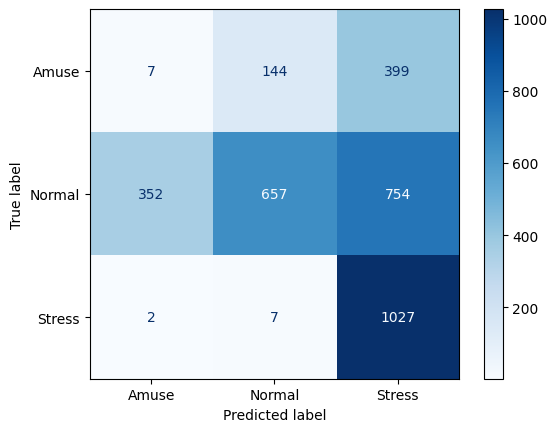

In [67]:
accuracy = accuracy_score(true_label, pred_label)
print('accuracy : ', np.round(accuracy,3))
precision = precision_score(true_label, pred_label, average='macro')
print('precision : ', np.round(precision,3))
recall = recall_score(true_label, pred_label,average='macro')
print('recall : ', np.round(recall,3))
specificity = recall_score(true_label, pred_label,average='macro')
print('specificity : ',np.round(specificity,3))
F1_score = f1_score(true_label, pred_label,average='macro')
print('F1_score : ', np.round(F1_score,3))

report = classification_report(true_label, pred_label, target_names=['Amuse', 'Normal','Stress'])
print(report)
confusion = confusion_matrix(true_label, pred_label)
disp = ConfusionMatrixDisplay(confusion, display_labels=['Amuse', 'Normal', 'Stress'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [68]:
save_model_path = 'D:/ICMLA/Model/'
model_name = 'Rhythm_원본_1DCNNBiLSTM_epochs(200)'
model.save(save_model_path + model_name + '.h5')

# K-Fold 만들기 

In [3]:
def load_Rhythm_level(data, window, overlap):
    rhythm_data = []
    for i in range(0, len(data), overlap):
        if len(data[i:i+window]) < window:
            break
        else:
            rhythm_data.append(data[i:i+window])
    return np.array(rhythm_data)  # 리스트 대신 NumPy 배열 반환

def shuffle_data(data, labels):
    # data와 label을 입력받아 무작위로 섞고 (인덱스 위치는 동일하게) Return
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    return data[indices], labels[indices]


def load_data(subjects, window, overlap):
    # Concatenate 함수를 사용하기 전에 리스트 대신 NumPy 배열 사용
    normal_data, stress_data, amuse_data = [], [], []
    normal_label, stress_label, amuse_label = [], [], []

    for i in subjects:
        df = pd.read_pickle(Data + i + '/' + i + '.pkl')
        ecg_v = df['signal']['chest']['ECG']
        label = df['label']

        amuse_ecg = ecg_v[np.where(label == 3)[0]]
        normal_ecg = ecg_v[np.where(label == 1)[0]]
        stress_ecg = ecg_v[np.where(label == 2)[0]]

        amuse_data.append(load_Rhythm_level(amuse_ecg, window, overlap))
        normal_data.append(load_Rhythm_level(normal_ecg, window, overlap))
        stress_data.append(load_Rhythm_level(stress_ecg, window, overlap))
    
    amuse = np.vstack(amuse_data)
    normal = np.vstack(normal_data)
    stress = np.vstack(stress_data)
    
    amuse_label = np.zeros(amuse.shape[0], np.int32)
    normal_label = np.ones(normal.shape[0], np.int32)
    stress_label = 2*np.ones(stress.shape[0], np.int32)
    
    Train = np.concatenate([amuse, normal, stress])
    Train_label = np.concatenate([amuse_label, normal_label, stress_label])
    
    train, train_y = shuffle_data(Train, Train_label)
    
    return train, train_y

In [4]:
def Plot_lr_curve(history):
    
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy'] 
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    plt.figure(figsize=(5, 5))
    plt.plot(acc, label='Training Accuracy')
    #plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.show()

    plt.figure(figsize=(5,5))
    plt.plot(loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

def Plot_confusion_matrix(true_d, pred):
    
    pred_label = []
    true_label = []
    for i in range(len(pred)):
        pred_label.append(np.argmax(pred[i]))
    
    for i in range(len(true_d)):
        true_label.append(np.argmax(true_d[i]))
        
        
    # Accuracy
    accuracy = accuracy_score(true_label, pred_label)
    print('accuracy : ', np.round(accuracy,3))
    
    # Precision
    precision = precision_score(true_label, pred_label, average='macro')
    print('precision : ', np.round(precision,3))
    
    # Recall
    recall = recall_score(true_label, pred_label,average='macro')
    print('recall : ', np.round(recall,3))
    
    # Specificity
    specificity = recall_score(true_label, pred_label,average='macro')
    print('specificity : ',np.round(specificity,3))
    
    # F1 Score
    F1_score = f1_score(true_label, pred_label,average='macro')
    print('F1_score : ', np.round(F1_score,3))

    report = classification_report(true_label, pred_label, target_names=['Amuse', 'Normal','Stress'])
    print(report)
    confusion = confusion_matrix(true_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion, display_labels=['Amuse', 'Normal', 'Stress'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Model

In [ ]:

    '''
    Conv1D(128, 10,activation='relu'),
    Conv1D(128, 10,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv1D(256, 3,activation='relu'),
    Conv1D(256, 3,activation='relu'),
    MaxPooling1D(2),
    
    Conv1D(512, 3,activation='relu'),
    Conv1D(512, 3,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    '''

In [14]:
model = tf.keras.Sequential([
    Conv1D(128, 10, activation='relu', input_shape=(3500, 1)),
    Conv1D(128, 10,activation='relu'),
    MaxPooling1D(2),
    
    
    Conv1D(256, 10,activation='relu'),
    Conv1D(256, 10,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.5),
    
    
    Conv1D(512, 10,activation='relu'),
    Conv1D(512, 10,activation='relu'),
    MaxPooling1D(2),  
    
    LSTM(128, return_sequences=True),
    LSTM(256),
    
    Dense(512, activation='LeakyReLU'),
    Dense(1024, activation='LeakyReLU'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 3491, 128)         1408      
                                                                 
 conv1d_49 (Conv1D)          (None, 3482, 128)         163968    
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 1741, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_50 (Conv1D)          (None, 1732, 256)         327936    
                                                                 
 conv1d_51 (Conv1D)          (None, 1723, 256)         655616    
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 861, 256)         0         
 g1D)                                                 

# K-Fold Main Code

Train: [ 1  2  3  4  5  6  7  8 10 12 13 14] Test [ 0  9 11]
Epoch 1/50
414/414 [==============================] - 59s 137ms/step - loss: 0.8433 - accuracy: 0.6378
Epoch 2/50
414/414 [==============================] - 57s 137ms/step - loss: 0.7322 - accuracy: 0.7015
Epoch 3/50
414/414 [==============================] - 57s 137ms/step - loss: 0.6788 - accuracy: 0.7275
Epoch 4/50
414/414 [==============================] - 57s 137ms/step - loss: 0.6344 - accuracy: 0.7495
Epoch 5/50
414/414 [==============================] - 57s 137ms/step - loss: 0.5389 - accuracy: 0.7840
Epoch 6/50
414/414 [==============================] - 57s 137ms/step - loss: 0.4657 - accuracy: 0.8187
Epoch 7/50
414/414 [==============================] - 57s 137ms/step - loss: 0.3734 - accuracy: 0.8569
Epoch 8/50
414/414 [==============================] - 57s 137ms/step - loss: 0.3006 - accuracy: 0.8891
Epoch 9/50
414/414 [==============================] - 56s 136ms/step - loss: 0.2259 - accuracy: 0.9133
Epoch 10/50


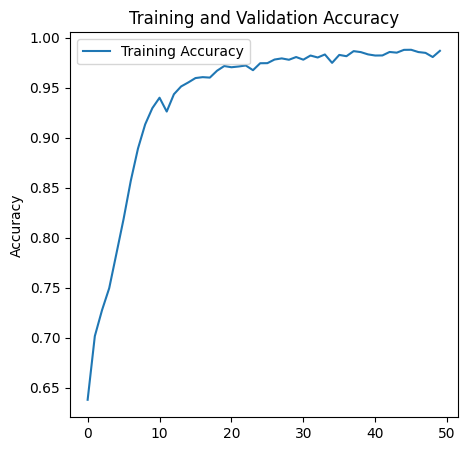

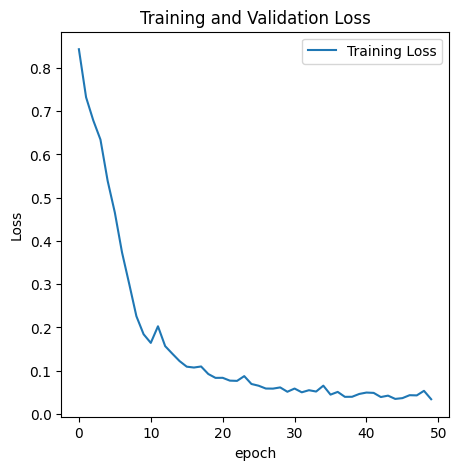

103/103 [==============================] - 5s 47ms/step
accuracy :  0.29
precision :  0.288
recall :  0.337
specificity :  0.337
F1_score :  0.197
              precision    recall  f1-score   support

       Amuse       0.24      0.10      0.15       545
      Normal       0.33      0.00      0.00      1746
      Stress       0.29      0.91      0.44       980

    accuracy                           0.29      3271
   macro avg       0.29      0.34      0.20      3271
weighted avg       0.31      0.29      0.16      3271



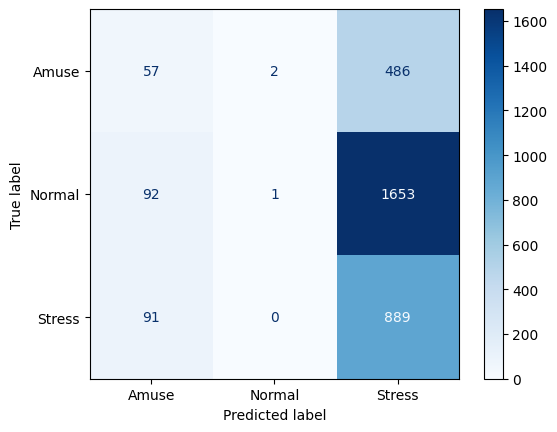

1 번째 검증
Train: [ 0  1  2  3  4  6  7  9 10 11 12 14] Test [ 5  8 13]
Epoch 1/50
412/412 [==============================] - 58s 136ms/step - loss: 0.9973 - accuracy: 0.5336
Epoch 2/50
412/412 [==============================] - 56s 136ms/step - loss: 0.9886 - accuracy: 0.5385
Epoch 3/50
412/412 [==============================] - 56s 136ms/step - loss: 0.9541 - accuracy: 0.5717
Epoch 4/50
412/412 [==============================] - 56s 136ms/step - loss: 0.9554 - accuracy: 0.5579
Epoch 5/50
412/412 [==============================] - 56s 136ms/step - loss: 0.9401 - accuracy: 0.5774
Epoch 6/50
412/412 [==============================] - 56s 137ms/step - loss: 0.8643 - accuracy: 0.6184
Epoch 7/50
412/412 [==============================] - 56s 136ms/step - loss: 0.6893 - accuracy: 0.6949
Epoch 8/50
412/412 [==============================] - 56s 137ms/step - loss: 0.6554 - accuracy: 0.7094
Epoch 9/50
412/412 [==============================] - 56s 136ms/step - loss: 0.6407 - accuracy: 0.7219
Epoc

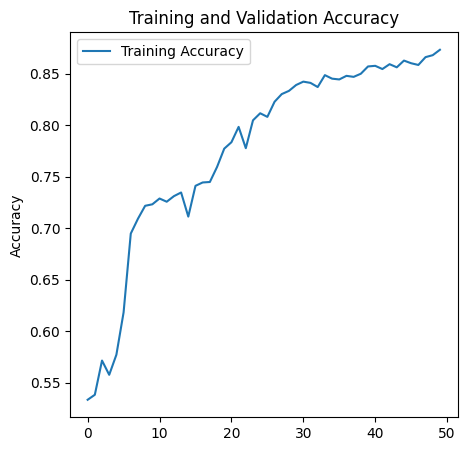

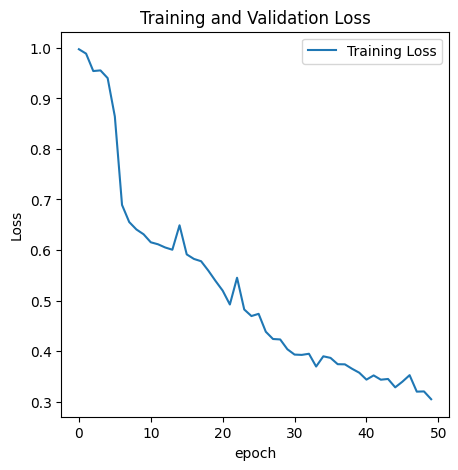

105/105 [==============================] - 5s 46ms/step
accuracy :  0.289
precision :  0.261
recall :  0.324
specificity :  0.324
F1_score :  0.177
              precision    recall  f1-score   support

       Amuse       0.15      0.06      0.08       550
      Normal       0.33      0.00      0.00      1767
      Stress       0.30      0.92      0.45      1014

    accuracy                           0.29      3331
   macro avg       0.26      0.32      0.18      3331
weighted avg       0.29      0.29      0.15      3331



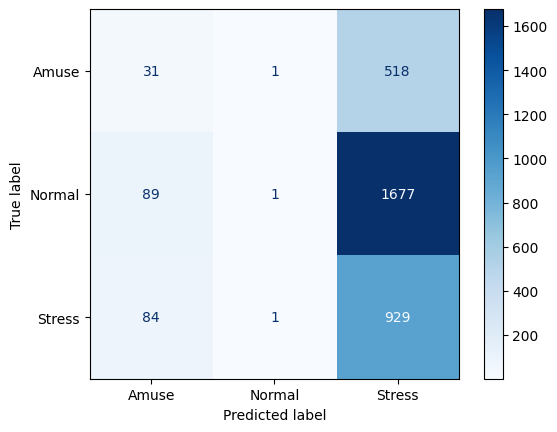

2 번째 검증
Train: [ 0  3  4  5  6  7  8  9 10 11 12 13] Test [ 1  2 14]
Epoch 1/50
413/413 [==============================] - 59s 138ms/step - loss: 0.9481 - accuracy: 0.5619
Epoch 2/50
413/413 [==============================] - 56s 137ms/step - loss: 0.8079 - accuracy: 0.6364
Epoch 3/50
413/413 [==============================] - 56s 137ms/step - loss: 0.7459 - accuracy: 0.6799
Epoch 4/50
413/413 [==============================] - 56s 136ms/step - loss: 0.5945 - accuracy: 0.7652
Epoch 5/50
413/413 [==============================] - 57s 137ms/step - loss: 0.5221 - accuracy: 0.7958
Epoch 6/50
413/413 [==============================] - 57s 137ms/step - loss: 0.4401 - accuracy: 0.8363
Epoch 7/50
413/413 [==============================] - 57s 137ms/step - loss: 0.3892 - accuracy: 0.8551
Epoch 8/50
413/413 [==============================] - 57s 137ms/step - loss: 0.3422 - accuracy: 0.8685
Epoch 9/50
413/413 [==============================] - 57s 138ms/step - loss: 0.2930 - accuracy: 0.8877
Epoc

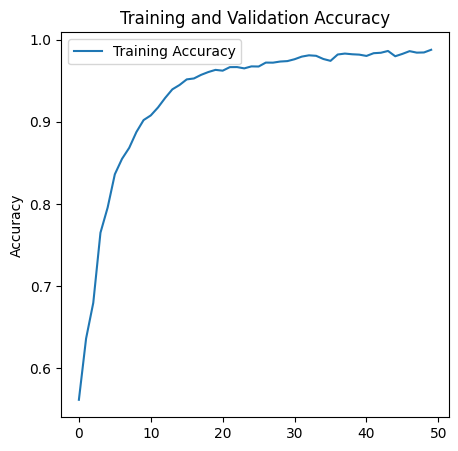

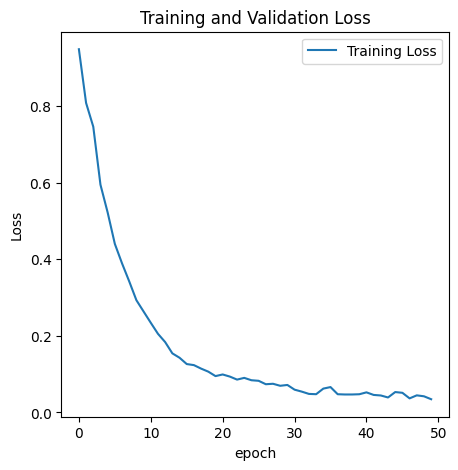

103/103 [==============================] - 5s 46ms/step
accuracy :  0.3
precision :  0.396
recall :  0.33
specificity :  0.33
F1_score :  0.178
              precision    recall  f1-score   support

       Amuse       0.14      0.03      0.05       554
      Normal       0.75      0.02      0.03      1734
      Stress       0.30      0.95      0.46       994

    accuracy                           0.30      3282
   macro avg       0.40      0.33      0.18      3282
weighted avg       0.51      0.30      0.16      3282



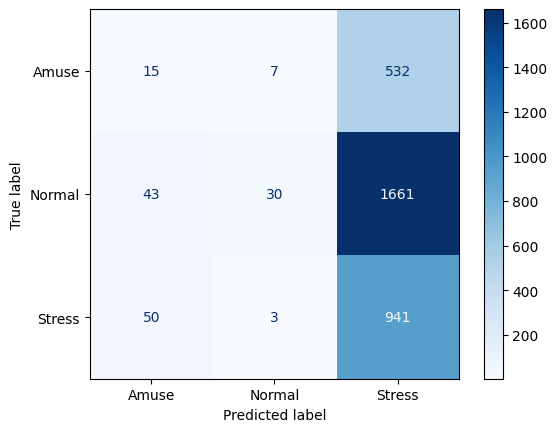

3 번째 검증
Train: [ 0  1  2  3  5  6  8  9 11 12 13 14] Test [ 4  7 10]
Epoch 1/50
413/413 [==============================] - 59s 139ms/step - loss: 0.8367 - accuracy: 0.6248
Epoch 2/50
413/413 [==============================] - 57s 138ms/step - loss: 0.7070 - accuracy: 0.6997
Epoch 3/50
413/413 [==============================] - 56s 137ms/step - loss: 0.6667 - accuracy: 0.7356
Epoch 4/50
413/413 [==============================] - 56s 136ms/step - loss: 0.6295 - accuracy: 0.7453
Epoch 5/50
413/413 [==============================] - 57s 137ms/step - loss: 0.5791 - accuracy: 0.7665
Epoch 6/50
413/413 [==============================] - 56s 136ms/step - loss: 0.5283 - accuracy: 0.7818
Epoch 7/50
413/413 [==============================] - 56s 136ms/step - loss: 0.4707 - accuracy: 0.8103
Epoch 8/50
413/413 [==============================] - 57s 137ms/step - loss: 0.3587 - accuracy: 0.8559
Epoch 9/50
413/413 [==============================] - 56s 136ms/step - loss: 0.2920 - accuracy: 0.8870
Epoc

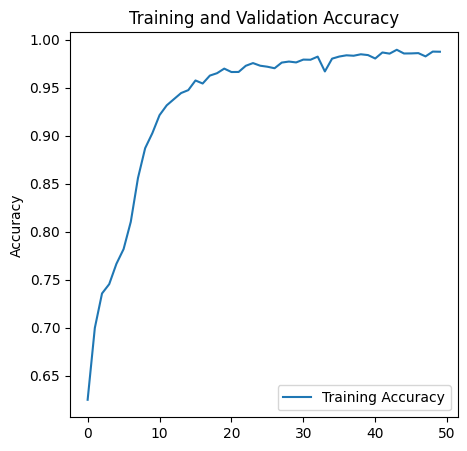

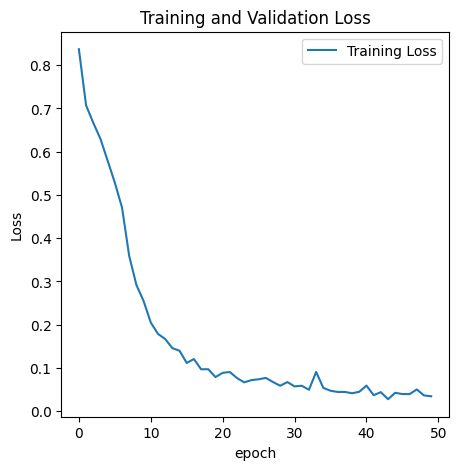

103/103 [==============================] - 5s 48ms/step
accuracy :  0.289
precision :  0.496
recall :  0.334
specificity :  0.334
F1_score :  0.179
              precision    recall  f1-score   support

       Amuse       0.19      0.06      0.09       557
      Normal       1.00      0.00      0.00      1764
      Stress       0.29      0.94      0.45       974

    accuracy                           0.29      3295
   macro avg       0.50      0.33      0.18      3295
weighted avg       0.66      0.29      0.15      3295



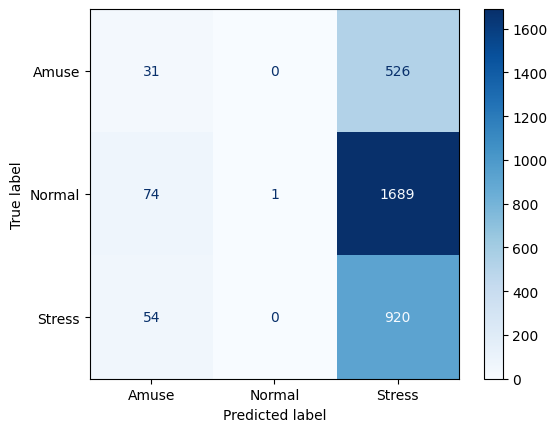

4 번째 검증
Train: [ 0  1  2  4  5  7  8  9 10 11 13 14] Test [ 3  6 12]
Epoch 1/50
412/412 [==============================] - 59s 139ms/step - loss: 0.9958 - accuracy: 0.5356
Epoch 2/50
412/412 [==============================] - 56s 137ms/step - loss: 0.9646 - accuracy: 0.5645
Epoch 3/50
412/412 [==============================] - 57s 138ms/step - loss: 0.9473 - accuracy: 0.5830
Epoch 4/50
412/412 [==============================] - 58s 141ms/step - loss: 0.8956 - accuracy: 0.6230
Epoch 5/50
412/412 [==============================] - 57s 138ms/step - loss: 0.8524 - accuracy: 0.6512
Epoch 6/50
412/412 [==============================] - 56s 136ms/step - loss: 0.8107 - accuracy: 0.6752
Epoch 7/50
412/412 [==============================] - 56s 137ms/step - loss: 0.7314 - accuracy: 0.7120
Epoch 8/50
412/412 [==============================] - 56s 137ms/step - loss: 0.6120 - accuracy: 0.7604
Epoch 9/50
412/412 [==============================] - 57s 138ms/step - loss: 0.5299 - accuracy: 0.7843
Epoc

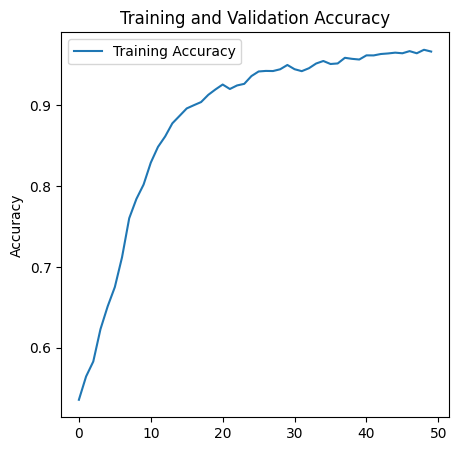

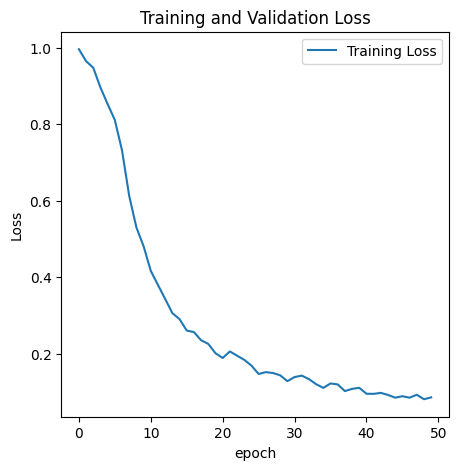

104/104 [==============================] - 6s 55ms/step
accuracy :  0.289
precision :  0.316
recall :  0.327
specificity :  0.327
F1_score :  0.18
              precision    recall  f1-score   support

       Amuse       0.18      0.05      0.08       552
      Normal       0.48      0.01      0.01      1766
      Stress       0.29      0.92      0.45       995

    accuracy                           0.29      3313
   macro avg       0.32      0.33      0.18      3313
weighted avg       0.37      0.29      0.15      3313



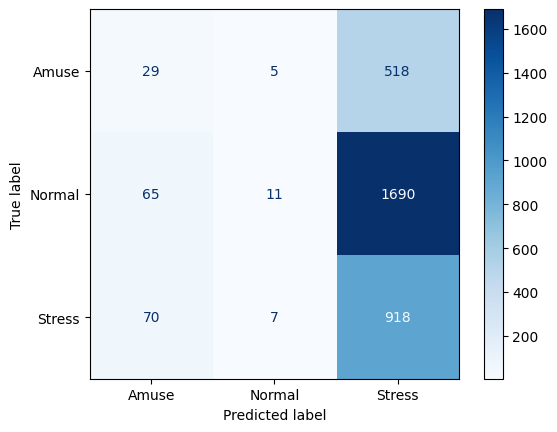

5 번째 검증
평균 정확도 :  0.5320635378360749


In [15]:
# library import
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model
from keras.utils import to_categorical

# Initial settings
Data = "D:/Database/WESAD/"
sampling_rate = 700
window = 5 * 700 # 5초 3,500 data point
overlap = 2 * 700 # 2초 중첩 1,400 data point 
n_split = 5 # num of Fold
random_state = 42
subjects = np.array(['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17'])
accuracies = [] # Fold accuracy list
fold_i = 0

# K-fold Code start
kf = KFold(n_splits=n_split, shuffle=True, random_state=random_state)

for train_index, test_index in kf.split(subjects):
    
    
    train_subjects, test_subjects = subjects[train_index], subjects[test_index]
    
    # Train Data load
    train_data, train_labels = load_data(train_subjects, window, overlap)
    # Test Data load
    test_data, test_labels = load_data(test_subjects, window, overlap)
    
    # One-hot Encoding
    train_y = to_categorical(train_labels)
    test_y = to_categorical(test_labels)
    
    print('Train:', train_index, 'Test', test_index)
    
    #model = MyCustomModel()
    # Model Training 
    model_clone = clone_model(model)
    model_clone.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model_clone.fit(train_data, train_y, epochs=50, batch_size=32) 
    scores = model_clone.evaluate(test_data, test_y)
    Plot_lr_curve(history)
    pred = model.predict(test_data)
    Plot_confusion_matrix(test_y, pred)
    
    
    accuracies.append(scores[1])
    
    fold_i += 1
    print(fold_i, '번째 검증')
    

average_accuracy = np.mean(accuracies)
print('평균 정확도 : ', average_accuracy)

In [91]:
np.argmax(test_y[8])

1

# Subclassing Model 생성 방법

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, LSTM, Bidirectional

class MyCustomModel(Model):
    def __init__(self):
        super(MyCustomModel, self).__init__()
        # Define all layers in the __init__ method
        self.conv1 = Conv1D(64, 5, activation='relu')
        self.conv2 = Conv1D(64, 5, activation='relu')
        self.pool1 = MaxPooling1D(2)
        self.norm1 = BatchNormalization()
        self.drop1 = Dropout(0.3)
        
        self.conv3 = Conv1D(128, 5, activation='relu')
        self.conv4 = Conv1D(128, 5, activation='relu')
        self.pool2 = MaxPooling1D(2)
        self.norm2 = BatchNormalization()
        self.drop2 = Dropout(0.3)
        
        self.conv5 = Conv1D(256, 5, activation='relu')
        self.conv6 = Conv1D(256, 5, activation='relu')
        self.norm3 = BatchNormalization()
        
        self.bi_lstm1 = Bidirectional(LSTM(32, return_sequences=True))
        self.bi_lstm2 = Bidirectional(LSTM(64))
        
        self.dense1 = Dense(512, activation='relu')
        self.dense2 = Dense(1024, activation='relu')
        self.dense3 = Dense(3, activation='softmax')

    def call(self, inputs):
        # Define the forward pass
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.drop1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.norm2(x)
        x = self.drop2(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.norm3(x)
        
        x = self.bi_lstm1(x)
        x = self.bi_lstm2(x)
        
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x